# Optimal Private Minimim Spanning Trees using Input Perturbation

In [1]:
import math
import random
from statistics import median
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from src.mst.pamst import pamst, comp_mst_weight
from src.mst.mst_utilities import compute_real_mst_weight, generate_random_complete_graph, compute_input_perturbation, generate_hard_instance, compute, generate_mi_instance

sns.set_theme(font_scale=1.5, rc={'text.usetex' : True})

In [2]:
# Computing Private Minimum Spanning Trees using Different Algorithms, Using l_infty neighboroing relationsip

# Privacy Parameters
#rho_values = [0.1,0.015,0.2,0.375,0.5,1,2,4,6,10, 100, 200]
rho_values = np.arange(0.001, 10, 0.1)
n = 100
sensitivity = 0.00996578428 # MI for dataset of size 1000 
# Experiment with random graph
# G = generate_random_complete_graph(n)
G = generate_mi_instance(100,0.1)

upper = []
for rho in rho_values:
    upper += [n**(3/2) * math.log(n/(2*rho))]

# Simply make an array to make visualization easier
real_weights = [compute_real_mst_weight(G)] * len(rho_values) 
print("Real MST Weight: " + str(real_weights[0]))
results = compute(G=G, sensitivity=sensitivity, rho_values=rho_values)

[[ 0.00000000e+00  5.31004406e-01  3.19922954e-01 ...  1.14183185e-19
   8.01587398e-17 -8.00388932e-17]
 [ 5.31004406e-01  0.00000000e+00  5.31004406e-01 ...  8.02640738e-17
   1.14183185e-19  8.01587398e-17]
 [ 3.19922954e-01  5.31004406e-01  0.00000000e+00 ...  2.78767466e-19
   8.02640738e-17  1.14183185e-19]
 ...
 [ 1.14183185e-19  8.02640738e-17  2.78767466e-19 ...  0.00000000e+00
   5.31004406e-01  3.19922954e-01]
 [ 8.01587398e-17  1.14183185e-19  8.02640738e-17 ...  5.31004406e-01
   0.00000000e+00  5.31004406e-01]
 [-8.00388932e-17  8.01587398e-17  1.14183185e-19 ...  3.19922954e-01
   5.31004406e-01  0.00000000e+00]]
Real MST Weight: 0.991103501181303
pamst: 7.83836017532833

























































































































































































































































































pamst: 0.779945988471258

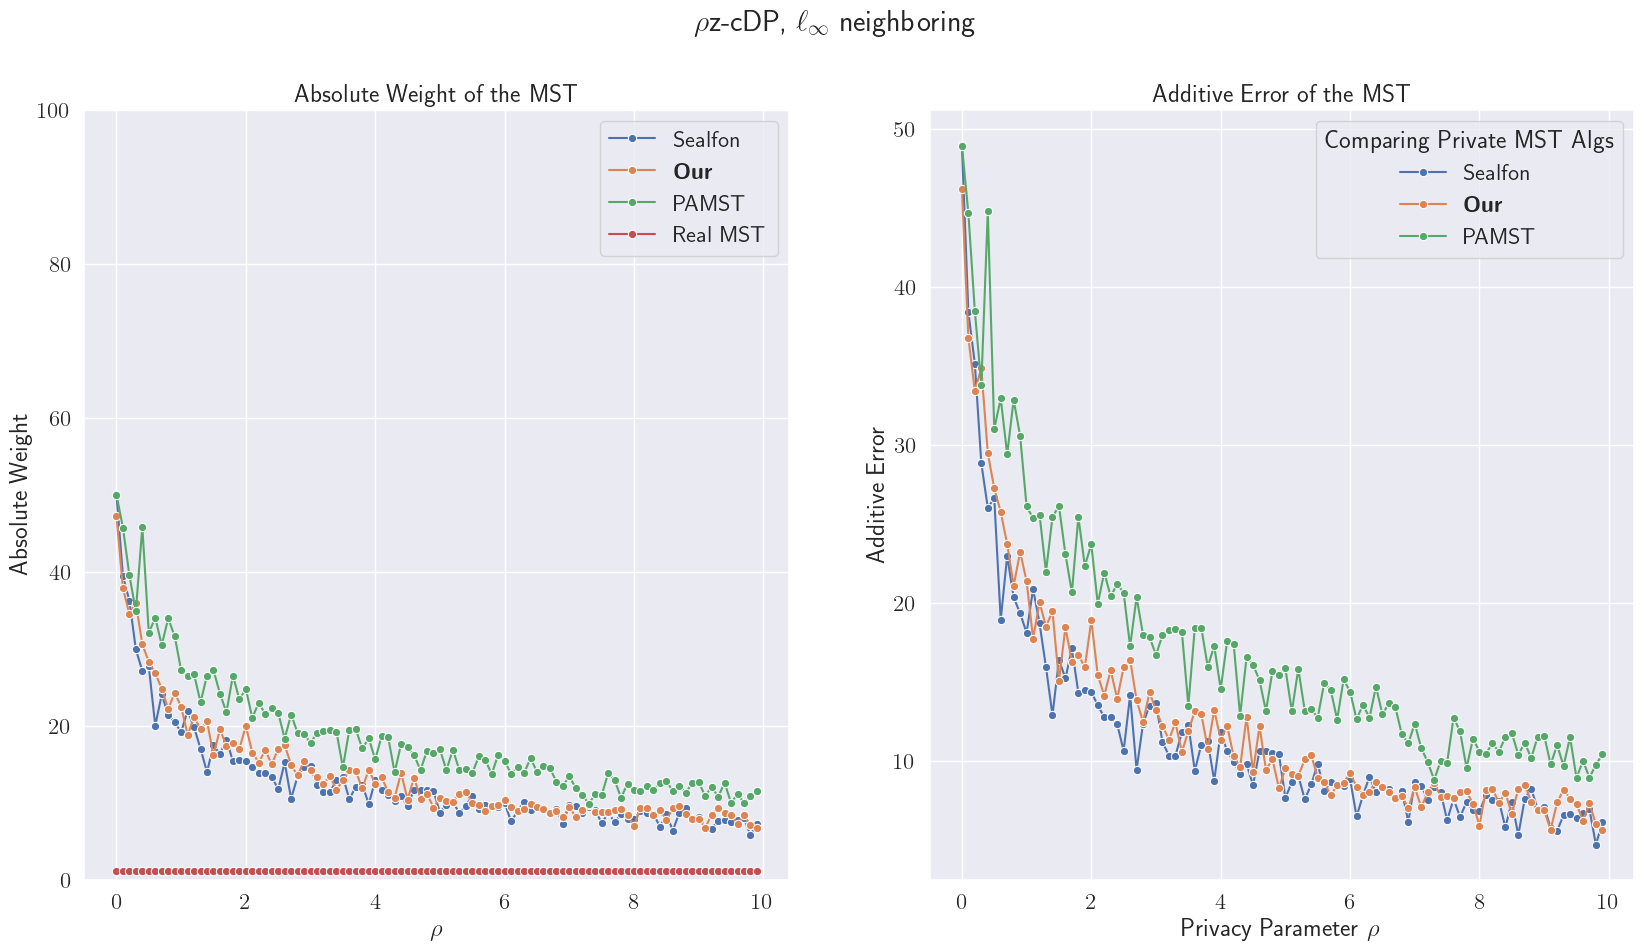

In [3]:
# Visualizing the results, Complete Graph

fig, axs = plt.subplots(1, 2, figsize=(20, 10))  # 2x2 grid
fig.suptitle("$\\rho $z-cDP, $\\ell_\\infty$ neighboring")

# Error of the MST
sns.lineplot(x= rho_values, y=results['sealfon'],marker='o', label="Sealfon", ax=axs[0])
#sns.lineplot(x=rho_values, y=upper, marker='o', label="upperbound", ax=axs[0])
sns.lineplot(x= rho_values, y=results['our'], marker='o', label="$\\textbf{Our}$", ax=axs[0])
sns.lineplot(x= rho_values, y=results['pamst'], marker='o', label="PAMST", ax=axs[0])
sns.lineplot(x= rho_values, y=results['real'], marker='o', label="Real MST", ax=axs[0])
axs[0].set_title("Absolute Weight of the MST")
# Error of the MST
sns.lineplot(x= rho_values, y=[sealfon - real for sealfon, real in zip(results['sealfon'], real_weights)] ,marker='o', label="Sealfon", ax=axs[1])
sns.lineplot(x= rho_values, y=[ours - real for ours, real in zip(results['our'], real_weights)] , marker='o', label="$\\textbf{Our}$", ax=axs[1])
sns.lineplot(x= rho_values, y=[pamst - real for pamst, real in zip(results['pamst'], real_weights)] , marker='o', label="PAMST", ax=axs[1])
axs[1].set_title("Additive Error of the MST")
axs[0].set_ylabel("Absolute Weight")
axs[0].set_ylim([0,100])

axs[0].set_xlabel("$\\rho$")
axs[1].set_ylabel("Additive Error")

# Set plot title and labels
# plt.title("Real MSTs")
plt.xlabel("Privacy Parameter $\\rho$")
# plt.ylabel("MST Weight")
plt.legend(title = "Comparing Private MST Algs")
plt.show()


# Experiments on Hard Instances
We are using Sealfons instance to create an hard instance.

Real MST Weight: 0
[255.88914266403188, 73.5649455387632, 50.96985726099633, 48.898288115691514, 40.195514048130924, 34.16505878569597, 31.81082745181895, 29.132528646722648, 27.275005516515087, 25.888733459683117, 23.241404955174975, 24.005504874179696, 23.533145255571643, 20.797337860565584, 21.92562109770431, 19.855406679112214, 18.290899885832246, 17.861791252409123, 17.803689066680995, 18.946081296922554, 17.6292836437288, 17.30887690144163, 16.712589523084713, 17.22781066524305, 16.195769814656874, 16.151579466303254, 15.0103480695772, 15.72490444887349, 12.868806022550247, 15.174911470724657]


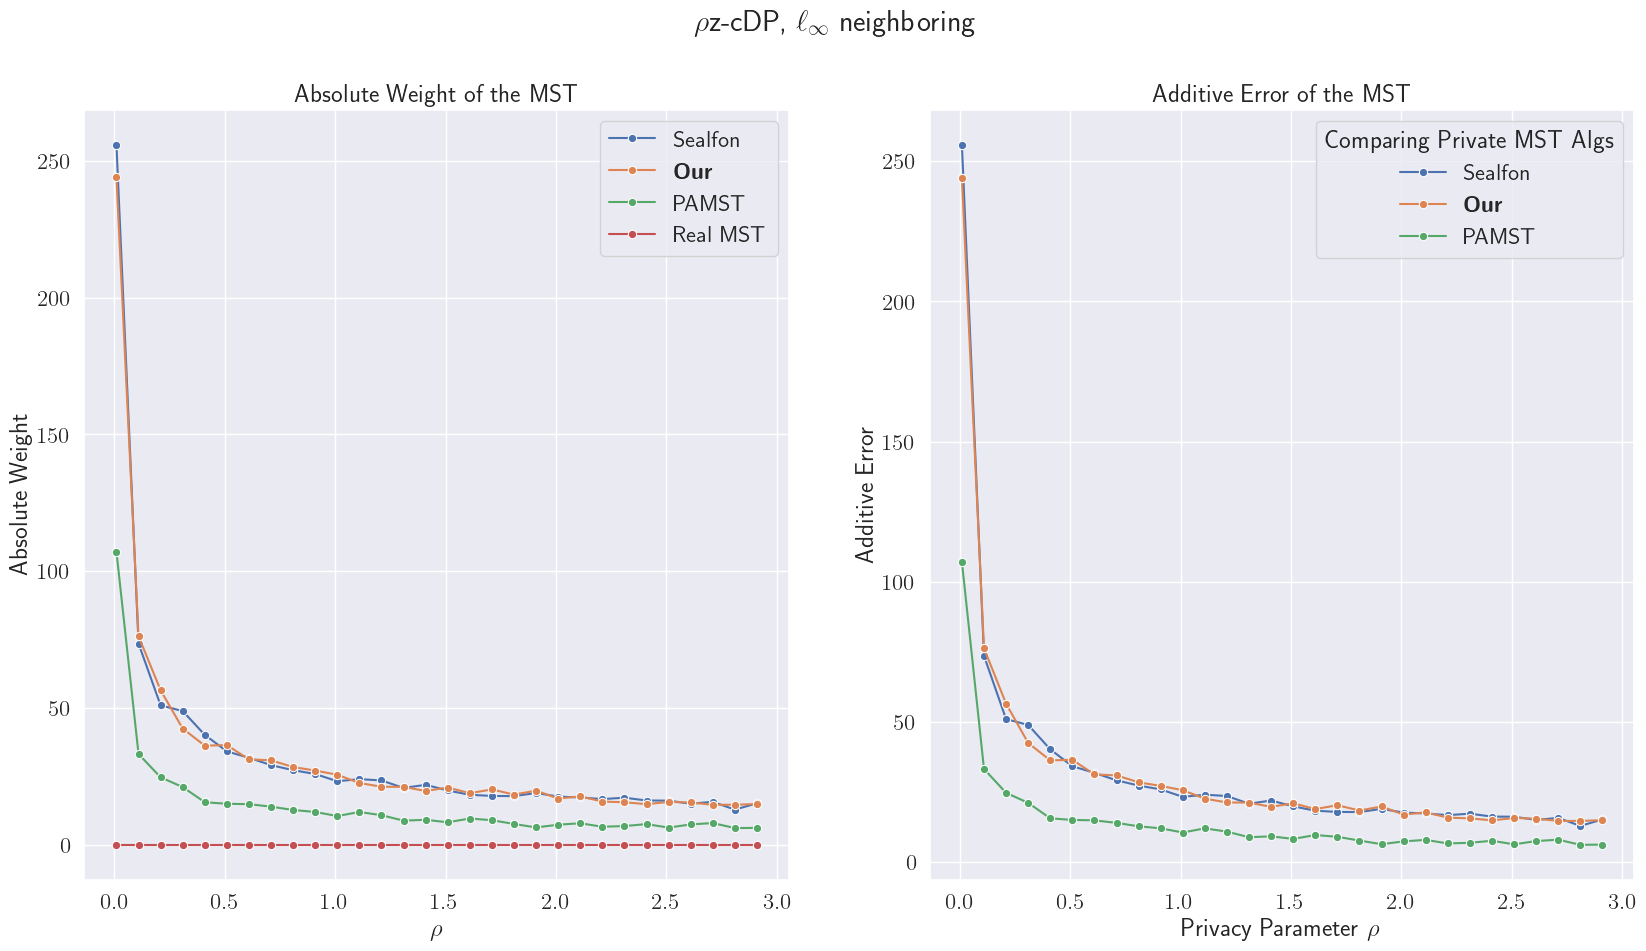

In [73]:
# Constructing an hard instance

# Privacy Parameters
rho_values = np.arange(0.01, 3, 0.1)
# rho_values = [0.001,0.02]
n = 250
sensitivity = 1

# Generate a enw graph
G = {}
for rho in rho_values:
    G[rho] = generate_hard_instance(n, 1/75* math.sqrt((n-1)/(2*rho)))
### Real Spanning Tree ###

# Simply make an array to make visualization easier

for rho in rho_values:
    real_weights = [compute_real_mst_weight(G[rho])] * len(rho_values)
print("Real MST Weight: " + str(real_weights[0]))

# Computing the upper bound
upper = []
for rho in rho_values:
    upper += [n**(3/2) * math.log(n)/(2*rho)]
    
### Pinot's PAMST Algorithm ###
pamst_weights = []
for rho in rho_values:
    noise_level = (2 * sensitivity * math.sqrt((n - 1) / (2 * rho)))  # Should be ok
    pamst_edges = pamst(G[rho], noise_level)  # Gives an iterator which should only be executed once!
    pamst_weights += [comp_mst_weight(pamst_edges)]

### Sealfon's Post Processing Technique ###

sealfon_weights = []
for rho in rho_values:
    noise_level = (n-1)/(2*rho)
    gaussNoise = lambda edge_weight: edge_weight + np.random.normal(0, noise_level)
    sealfon_weights += [compute_input_perturbation(G[rho].copy(), gaussNoise, alg='kruskal')]
    # print("Sealfon MST Weight: " + str(weight_sealfon))
print(sealfon_weights)

### Finally: Our Approach ###
our_weights = []
for rho in rho_values:
    noise_level = sensitivity * math.sqrt((2*rho)/(n-1))
    expNoise = lambda edge_weight: np.log(np.random.exponential(1)) + noise_level * edge_weight
    our_weights += [compute_input_perturbation(G[rho].copy(), expNoise)]
# Visualizing the results, Complete Graph

fig, axs = plt.subplots(1, 2, figsize=(20, 10))  # 2x2 grid
fig.suptitle("$\\rho $z-cDP, $\\ell_\\infty$ neighboring")

# Error of the MST
sns.lineplot(x=rho_values, y=sealfon_weights, marker='o', label="Sealfon", ax=axs[0])
#sns.lineplot(x=rho_values, y=upper, marker='o', label="upperbound", ax=axs[0])
sns.lineplot(x=rho_values, y=our_weights, marker='o', label="$\\textbf{Our}$", ax=axs[0])
sns.lineplot(x=rho_values, y=pamst_weights, marker='o', label="PAMST", ax=axs[0])
sns.lineplot(x=rho_values, y=real_weights, marker='o', label="Real MST", ax=axs[0])
axs[0].set_title("Absolute Weight of the MST")

# Error of the MST
sns.lineplot(x=rho_values, y=[sealfon - real for sealfon, real in zip(sealfon_weights, real_weights)], marker='o',
             label="Sealfon", ax=axs[1])
sns.lineplot(x=rho_values, y=[ours - real for ours, real in zip(our_weights, real_weights)], marker='o',
             label="$\\textbf{Our}$", ax=axs[1])
sns.lineplot(x=rho_values, y=[pamst - real for pamst, real in zip(pamst_weights, real_weights)], marker='o',
             label="PAMST", ax=axs[1])
axs[1].set_title("Additive Error of the MST")
axs[0].set_ylabel("Absolute Weight")
axs[0].set_xlabel("$\\rho$")
axs[1].set_ylabel("Additive Error")

# Set plot title and labels
# plt.title("Real MSTs")
plt.xlabel("Privacy Parameter $\\rho$")
# plt.ylabel("MST Weight")
plt.legend(title="Comparing Private MST Algs")
plt.show()

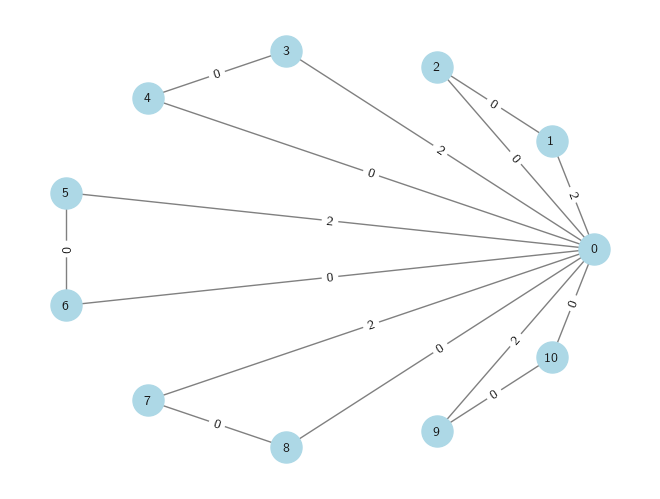

In [17]:
# Visualization of our hard instance
pos = nx.circular_layout(G)

G = generate_hard_instance(5, 1)
T = nx.minimum_spanning_tree(G, algorithm='prim')

# Draw the graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold', edge_color='gray')

# Extract edge weights and display them
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

# Show the plot
plt.show()


[[0.         0.53100441 0.31992295]
 [0.53100441 0.         0.53100441]
 [0.31992295 0.53100441 0.        ]]


KeyboardInterrupt: 

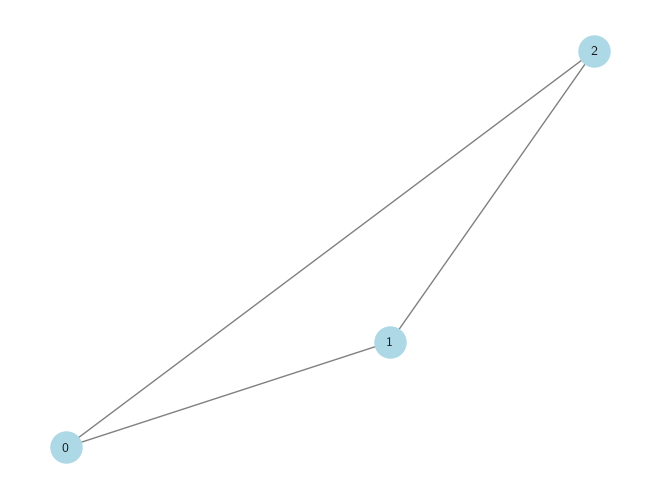

In [9]:
# Visualization MI Cell

G2 = generate_mi_instance(3, 0.1)
pos = nx.spiral_layout(G)

# Draw the graph
nx.draw(G2, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold', edge_color='gray')

# Extract edge weights and display them
edge_labels = nx.get_edge_attributes(G2, 'weight')
nx.draw_networkx_edge_labels(G2, pos, edge_labels=edge_labels, font_size=10)
